# Time taken to complete degree
Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?

In [177]:
import requests as req
import urllib
import pandas as pd
from bs4 import BeautifulSoup as bes
import inspect
import copy
from tqdm import tqdm
import numpy as np
import pickle


#Add the base url where the form is
base_url = "http://isa.epfl.ch/imoniteur_ISAP/!gedpublicreports.htm?ww_i_reportmodel=133685247"
full_url = "http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=&ww_x_PERIODE_ACAD=213638028&zz_x_PERIODE_PEDAGO=&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=2936286&dummy=ok"

Applying the filters to get the Bachelor semester 1 in informatique in 2015-16 gives the following url: 
```
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_b_list=1&ww_i_reportmodel=133685247&ww_c_langue=&ww_i_reportModelXsl=133685270&zz_x_UNITE_ACAD=&ww_x_UNITE_ACAD=249847&zz_x_PERIODE_ACAD=&ww_x_PERIODE_ACAD=213638028&zz_x_PERIODE_PEDAGO=&ww_x_PERIODE_PEDAGO=249108&zz_x_HIVERETE=&ww_x_HIVERETE=2936286&dummy=ok
```
Feeding this url to postman interceptor gives us the following parameter values:
```
ww_b_list:1
ww_i_reportmodel:133685247
ww_c_langue:
ww_i_reportModelXsl:133685270
zz_x_UNITE_ACAD:
ww_x_UNITE_ACAD:249847
zz_x_PERIODE_ACAD:
ww_x_PERIODE_ACAD:213638028
zz_x_PERIODE_PEDAGO:
ww_x_PERIODE_PEDAGO:249108
zz_x_HIVERETE:
ww_x_HIVERETE:2936286
dummy:ok
```
We used inspect element  to get the url of the page that displays only the data table without the form. The url was as follows:
```
http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?ww_x_GPS=1897032870&ww_i_reportModel=133685247&ww_i_reportModelXsl=133685270&ww_x_UNITE_ACAD=249847&ww_x_PERIODE_ACAD=213638028&ww_x_PERIODE_PEDAGO=249108&ww_x_HIVERETE=2936286
```
Feeding this url to postman interceptor gives us the following parameter values:
```
ww_x_GPS:1897032870
ww_i_reportModel:133685247
ww_i_reportModelXsl:133685270
ww_x_UNITE_ACAD:249847
ww_x_PERIODE_ACAD:213638028
ww_x_PERIODE_PEDAGO:249108
ww_x_HIVERETE:2936286
```
Looking at the HTML code, we can figure out what each of the parameters stands for:
+ **ww_x_GPS**: There might be several lists which match our search. This specifies which list to open. giving -1 opens tous, which is all. So we set this to -1
+ **ww_i_reportModel and ww_i_reportModelXsl**: Selecting whether to use HTML or excel. We always want to use HTML so we fix it to the values we got above in postman interceptor.
+ **ww_x_UNITE_ACAD**: We are only considering 'Informatique' so we fix it to the value above found using interceptor, for informatique.
+ **ww_x_PERIODE_ACAD**: We need to vary the academic period. We will get a dictionary for what value corresponds to which academic year from the HTML source using beautiful soup.
+ **ww_x_PERIODE_PEDAGO**: We also need a dictionary for this just as we do for ww_x_PERIODE_ACAD.
+ **ww_x_HIVERETE**: Same as above.

Now we need to get the dictionaries for the required fields

In [163]:
r = req.get( full_url ) 
soup = bes(r.text, 'lxml') #applies beautifulSoup on the HTML
#print (soup.prettify())

'option' corresponds to the dropdown menus in the form. We get a dictionary which relates each possibility in each of the drop down menus to the value of the query in the server.

In [164]:
dicti = {}
for select in soup.findAll('select'):
    name = select['name'].strip()
    dicti[name] = {}
    for option in select.findAll('option'):
        if(option['value'] != 'null'):
            strng = option.string.strip()
            dicti[name][strng] = option['value'].strip()

This gives us the following dictionary.

In [165]:
dicti

{'ww_x_HIVERETE': {"Semestre d'automne": '2936286',
  'Semestre de printemps': '2936295'},
 'ww_x_PERIODE_ACAD': {'2007-2008': '978181',
  '2008-2009': '978187',
  '2009-2010': '978195',
  '2010-2011': '39486325',
  '2011-2012': '123455150',
  '2012-2013': '123456101',
  '2013-2014': '213637754',
  '2014-2015': '213637922',
  '2015-2016': '213638028',
  '2016-2017': '355925344'},
 'ww_x_PERIODE_PEDAGO': {'Bachelor semestre 1': '249108',
  'Bachelor semestre 2': '249114',
  'Bachelor semestre 3': '942155',
  'Bachelor semestre 4': '942163',
  'Bachelor semestre 5': '942120',
  'Bachelor semestre 5b': '2226768',
  'Bachelor semestre 6': '942175',
  'Bachelor semestre 6b': '2226785',
  'Master semestre 1': '2230106',
  'Master semestre 2': '942192',
  'Master semestre 3': '2230128',
  'Master semestre 4': '2230140',
  'Mineur semestre 1': '2335667',
  'Mineur semestre 2': '2335676',
  'Mise à niveau': '2063602308',
  'Projet Master automne': '249127',
  'Projet Master printemps': '3781783

We know from postman interceptor the parameters in the above dictionary are not enough to make the request to the server. We are missing three parameters which are fixed. We now add them to te dictionary.

In [166]:
gps = 'ww_x_GPS'
dicti[gps] = {}
r1 = 'ww_i_reportModel'
dicti[r1] = {}
r2 = 'ww_i_reportModelXsl'
dicti[r2] = {}
dicti['ww_x_GPS']['tous'] = '-1'  #for 'tous'. fixed
dicti['ww_i_reportModel']['html'] = '133685247'  #fixed
dicti['ww_i_reportModelXsl']['xls'] = '133685270'  #fixed to HTML

We restrict the dictionary to keep only values we are interested in.

In [167]:
# 'ww_x_HIVERETE' is redundant
del dicti['ww_x_HIVERETE'] 

#keep only informatique for 'ww_x_UNITE_ACAD'
for key in list(dicti['ww_x_UNITE_ACAD']): 
    if(key != 'Informatique'):
        del dicti['ww_x_UNITE_ACAD'][key]
        
#keeps only the bachelor semesters
for key in list(dicti['ww_x_PERIODE_PEDAGO']): 
    if(key.startswith('Bachelor') == False):
        del dicti['ww_x_PERIODE_PEDAGO'][key]

Our dictionary now has precisely only the entries that we need.

In [168]:
dicti

{'ww_i_reportModel': {'html': '133685247'},
 'ww_i_reportModelXsl': {'xls': '133685270'},
 'ww_x_GPS': {'tous': '-1'},
 'ww_x_PERIODE_ACAD': {'2007-2008': '978181',
  '2008-2009': '978187',
  '2009-2010': '978195',
  '2010-2011': '39486325',
  '2011-2012': '123455150',
  '2012-2013': '123456101',
  '2013-2014': '213637754',
  '2014-2015': '213637922',
  '2015-2016': '213638028',
  '2016-2017': '355925344'},
 'ww_x_PERIODE_PEDAGO': {'Bachelor semestre 1': '249108',
  'Bachelor semestre 2': '249114',
  'Bachelor semestre 3': '942155',
  'Bachelor semestre 4': '942163',
  'Bachelor semestre 5': '942120',
  'Bachelor semestre 5b': '2226768',
  'Bachelor semestre 6': '942175',
  'Bachelor semestre 6b': '2226785'},
 'ww_x_UNITE_ACAD': {'Informatique': '249847'}}

Also, we dont need the tags of the values anymore, so we change the dictionary to have the values simply as a list. This makes it easier to iterate over all possibilities for the parameters.

In [169]:
new_dict = {}
for key, value in dicti.items():
    temp = []
    for k, v in dicti[key].items():
        temp.append(v)
    new_dict[key] = copy.copy(temp)

Now we have a dictionary that we can start using to generate the requests. A query corresponds to one possible set of parameters. We generate a list of all the possible set of parameters that we are interested in for this question.

Note that we need to vary only 'ww_x_PERIODE_PEDAGO' and 'ww_x_PERIODE_ACAD' as 'ww_x_HIVERETE is redundant and the other values are fixed.

In [170]:
new_dict

{'ww_i_reportModel': ['133685247'],
 'ww_i_reportModelXsl': ['133685270'],
 'ww_x_GPS': ['-1'],
 'ww_x_PERIODE_ACAD': ['213638028',
  '123456101',
  '978195',
  '39486325',
  '213637754',
  '213637922',
  '978181',
  '123455150',
  '978187',
  '355925344'],
 'ww_x_PERIODE_PEDAGO': ['2226768',
  '2226785',
  '942155',
  '249114',
  '942120',
  '942175',
  '942163',
  '249108'],
 'ww_x_UNITE_ACAD': ['249847']}

The following code gives us a set of parameters that we can use along with the requests library to generate the necessary queries. We construct this using the above dictionary. Basically we get all possible combinations for the possibilities for each parameter which we need to pass to requests.get.

In [171]:
import itertools 

combinations = [[{key: value} for (key, value) in zip(new_dict, values)] 
                for values in itertools.product(*new_dict.values())]

params = []

for i in range(len(combinations)):
    temp = combinations[i][0].copy()
    for j in range(1,len(combinations[i])):
        temp.update(combinations[i][j])
    params.append(temp)

In [172]:
def get_key(dicti, value):
    for k, v in dicti.items():
        if v == value:
            return k

Now we have the parameters for all qeuries we are interested in as a list. We now do the queries to get a list of dataframes.

In [173]:
# No need to run this since it has been pickeled
'''
yr = 'ww_x_PERIODE_ACAD'
sem = 'ww_x_PERIODE_PEDAGO'

df_list = []
query = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html?'
for param in tqdm(params):
    r = req.get(query, param)
    try:
        df = pd.read_html(r.url,header=0,skiprows=1)[0]
    except:
        continue
    
    #We were getting two lists for some queries. This is so that the lists are combined properly. Other
    df = df[ (df['Civilité'] == 'Monsieur') | (df['Civilité'] == 'Madame') ]     
    df = df.dropna(1)
        
    year_val = param[yr]
    df['Year'] = get_key( dicti[yr], year_val)
    
    sem_val = param[sem]
    df['Semester'] = get_key( dicti[sem], sem_val)
    df_list.append(df)
'''

In [174]:
#Concat the dataFrames to get one big dataframe
df_bachelor = pd.concat(df_list,ignore_index=True)

In [175]:
#Conver 'No Sciper' to int
df_bachelor['No Sciper'] = df_bachelor['No Sciper'].apply(lambda x: int(x))

### Pickling the DataFrame list

Since the list of DataFrame is computationally intensive, and we do not want to send the request to servers everytime, we saved the dataframes into another file, df_bachelor.p

In [178]:
# saving the file
'pickle.dump(df_bachelor, open( "df_bachelor.p", "wb" ) )'
#needs to be dumped only once

In [187]:
# opening the file
df_bachelor = pickle.load( open( "df_bachelor.p", "rb" ) )

In [227]:
df = df_bachelor

# We cond=firm that there are no entries for Bachelor semestre 6b and 5b
test = df[(df['Semester'] == 'Bachelor semestre 5b') | (df['Semester'] == 'Bachelor semestre 6b')]
test

,Civilité,Nom Prénom,Statut,No Sciper,Year,Semester


# Analysis
New we have the dataframe with all the data which we need to work with. We now start with the analysis of the data. Our assumptions are as follows:
+ We only include students for whom we have both bachelor semester 1, and either bachelor semester 5 or 6 until the previous academic year. So we do not include students doing their 5th semester this semester. 
+ The bachelor only starts in the Autumn semester. So the first semester of bachelor cannot be Bachelor semester 2.
+ We do not account for leaves.

We start by adding rows for first semester and last semester and removing students who have not completed the degree. We assume that those who do not have a record for semester 6 did not complete the degree.

In [228]:
#The main dataFrame we are working with
df = df.sort_values(by=['Nom Prénom', 'Year', 'Semester'])

In [229]:
#Semester number
df['Semester'] = df['Semester'].str[18].astype(int)

#0 if autumn semester and 1 if spring semester
df['Sem type'] = (df['Semester'] + 1)%2

# NOTE: If this cell is run more than once it will give an error since an str would have been converted to int

In [230]:
#Denote each academic year by only a single year, which is the starting year
df['Year'] = df['Year'].str[0:4].astype(int)


In [231]:
df = df.sort_values(by=['Nom Prénom', 'Year', 'Semester'])
df.head()

,Civilité,Nom Prénom,Statut,No Sciper,Year,Semester,Sem type
4043,Monsieur,Aapro Niccolò,Présent,170617,2007,3,0
4255,Monsieur,Aapro Niccolò,Congé,170617,2007,4,1
3801,Monsieur,Abate Bryan Jeremy,Présent,246671,2014,1,0
3300,Monsieur,Abate Bryan Jeremy,Présent,246671,2014,2,1
0,Monsieur,Abate Bryan Jeremy,Présent,246671,2015,3,0


In [232]:
# orgnaization

#DataFrame for getting the first sem bachelor semester. Recall that the dataFrame has been sorted by year and semester
first_row = df.groupby('Nom Prénom').first()
first_row.rename(columns={'Year':'first_year', 'Semester':'first_semester'}, inplace=True)
first_row = first_row[['Civilité','first_year','first_semester' ]]
first_row.reset_index(inplace=True)


In [233]:
# dataFrame for last sem of Bachelor semester 
last_row = df.groupby('Nom Prénom').last()
last_row.rename(columns={'Year':'last_year', 'Semester':'last_semester'}, inplace=True)
last_row = last_row[['Civilité','last_year','last_semester', 'Sem type' ]]
last_row.reset_index(inplace=True)

In [234]:
#The first sem should be Bachelor Semester 1 
first_row = first_row[first_row['first_semester'] == 1]


In [235]:
# The last sem should be bachelor sem 5 or 6 but if it is 5, it should not be in 2016
last_row = last_row[ (last_row['last_semester'] == 6 ) | (last_row['last_semester'] == 5 ) ]
last_row = last_row[ last_row['last_year'] != 2016 ]

In [236]:
#We do an inner join of last_row and first_row so that only students in both tables remain
df_dur = pd.merge(first_row, last_row, how='inner', on='Nom Prénom' )



# Calculating duration
We calculate the duration in months, assuming one semester is 6 months. So  we have number of months = (last_year - first_year)x12. We need to add 6 months to this to get the number we expect because starting in sem 1, year i and finishing in sem 1, year j is 2(j-i)+1 semesters. So we add 6 months to take care of this +1. But this is not enough because we also have to take into account the semester in which the student finished. If he/she finished in the spring semester we need to add 6 more months.

In [237]:
df_dur['Duration in Months'] = (df_dur['last_year'] - df_dur['first_year'])*12 + (df_dur['Sem type'] + 1)*6 
# We remove students with duration less than 36 months
df_dur = df_dur[df_dur['Duration in Months'] >= 36 ]
df_dur

,Nom Prénom,Civilité_x,first_year,first_semester,Civilité_y,last_year,last_semester,Sem type,Duration in Months
0,Aiulfi Loris Sandro,Monsieur,2010,1,Monsieur,2015,6,1,72
1,Alfonso Peterssen Alfonso,Monsieur,2013,1,Monsieur,2015,6,1,36
3,Amorim Afonso Caldeira Da Silva Pedro Maria,Monsieur,2011,1,Monsieur,2014,6,1,48
6,Andreina Sébastien Laurent,Monsieur,2011,1,Monsieur,2014,6,1,48
7,Angel Axel,Monsieur,2010,1,Monsieur,2012,6,1,36
8,Angerand Grégoire Georges Jacques,Monsieur,2011,1,Monsieur,2015,6,1,60
9,Antognini Marco,Monsieur,2009,1,Monsieur,2012,6,1,48
10,Arnfred Jonas,Monsieur,2008,1,Monsieur,2010,6,1,36
11,Arévalo Christian,Monsieur,2007,1,Monsieur,2009,6,1,36
12,Aubelle Flavien,Monsieur,2007,1,Monsieur,2011,6,1,60


In [238]:
# CLean table
del df_dur['Civilité_x']
df_dur.rename(columns={'Civilité_y':'Civilité'}, inplace=True)


In [239]:
# Get the mean and median for the total population
spec_general = df_dur['Duration in Months']
print('mean =',  spec_general.mean(), ';median =',  spec_general.median())


mean = 42.30810810810811 ;median = 36.0


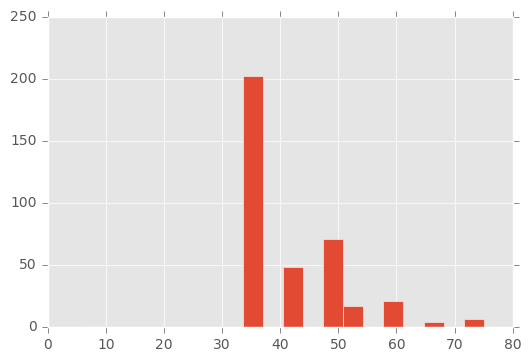

In [240]:
#Plot frequency of time taken
spec_general.hist(bins = 20, range=[6, 75])


# Females
Statistical analysis for female students

In [241]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

madames = df_dur[df_dur['Civilité'] == 'Madame']
print('mean =',  madames['Duration in Months'].mean(), ';median =',  madames['Duration in Months'].median())


mean = 38.76923076923077 ;median = 36.0


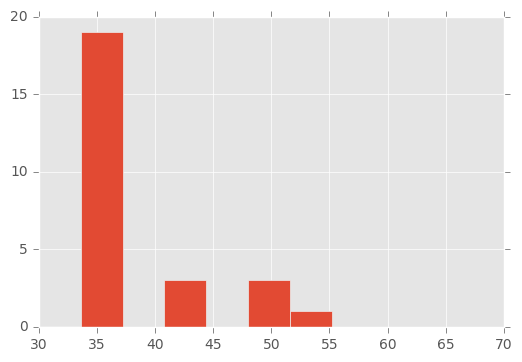

In [243]:
madames['Duration in Months'].hist(bins = 10, range=[30, 66])


# Males
Statistical analysis for male students

In [244]:
monsieurs = df_dur[df_dur['Civilité'] == 'Monsieur']
print('mean =',  monsieurs['Duration in Months'].mean(), ';median =',  monsieurs['Duration in Months'].median())


mean = 42.575581395348834 ;median = 36.0


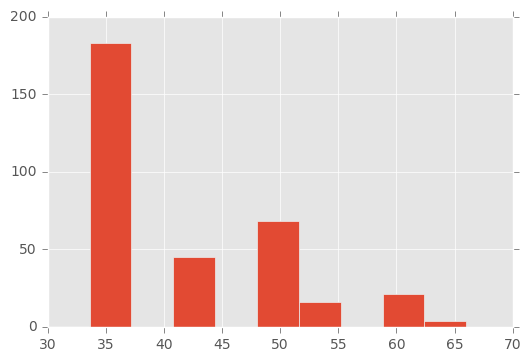

In [246]:
monsieurs['Duration in Months'].hist(bins = 10, range=[30, 66])


# Hypothesis testing
We want to check whether the the difference in average time taken by males and females to complete the degree is statistically significant. The null hypothesis is that the male and the female population have equal means. For this we use the Welch's T-Test. According to wikipedia this test 'is more reliable when the two samples have unequal variances and unequal sample sizes' which is the case for us.

In [247]:
import scipy.stats as stats

In [248]:
stats.ttest_ind(a = madames['Duration in Months'], b= monsieurs['Duration in Months'], equal_var=False)

Ttest_indResult(statistic=-3.3969905960391378, pvalue=0.0016239632567067307)

Since the p-value is less than 0.05, we conclude that we must reject the null hypothesis. The difference in average is therefore statistically significant.